In [1]:
from utils import (
    visualize, CONSTRUCT_ER, CONSTRUCT_RL, xvisualize,
    from_sparql, prefixes, show_svg)
from rdflib import Graph
import sparql_dataframe

endpoint = "http://virtuoso:8890/sparql"


# d3f

D3fend is a Mitre ontology that models Security entities and aims at providing a common, vendor-independent, vocabulary for cybersecurity.

This notebook provides an overview of d3fend with various examples.

All d3fend classes subclass either d3f:D3FENDThing or d3f:ATTACKThing




In [2]:
# Load the ontology

d3f = Graph()
d3f.parse("vocabularies/d3fend.ttl", format="turtle")

<Graph identifier=Ne83ec1c4f63943938f8698a75581be4b (<class 'rdflib.graph.Graph'>)>

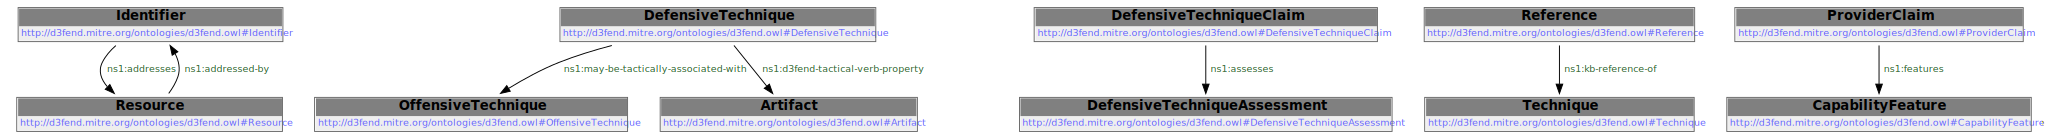

In [3]:
# Explicit relations between classes. More can be inferred from owl:Restrictions
ret = d3f.query("""
CONSTRUCT {
    ?object ?rel ?subject 
}
WHERE {
OPTIONAL {
?rel rdfs:domain ?object;
     rdfs:range   ?subject 
.
}
OPTIONAL {
?object rdfs:subClassOf [
 a owl:Restriction;
 owl:onProperty ?rel;
 owl:someValuesFrom ?subject
]
}
FILTER (
regex(str(?subject), "http://d3fend.mitre.org", "i")
)
}
""")
show_svg(ret.graph)

In [6]:
# Explicit relations between classes. More can be inferred from owl:Restrictions
ret = d3f.query("""
CONSTRUCT {
    ?object ?rel ?subject 
}
WHERE {

?object rdfs:subClassOf [
 a owl:Restriction;
 owl:onProperty ?rel;
 owl:someValuesFrom ?subject
]
. ?object (rdf:type|rdfs:subClassOf)* d3f:D3FENDThing

FILTER (
regex(str(?subject), "http://d3fend.mitre.org", "i")
)
}
""")
show_svg(ret.graph)

The principal classes of D3F are:

- Defensive and Offensive Technique
- Digital Object representing a digital object like a Software or a File

These derive from more general classes:

- Artifact
- Defensive and Offensive Tactic, categorizing various Techniques

- Technique Reference


In [36]:
overview = """
SELECT DISTINCT 
?parent ?entity 
WHERE { 
?sub rdfs:subClassOf ?class ;
rdfs:label ?entity 
.
?class rdfs:label ?parent
 VALUES (?class) { (d3f:D3FENDThing) (d3f:ATTACKThing)}
} 
ORDER BY (?parent)
"""
sparql_dataframe.get(endpoint, prefixes+ overview)

,parent,entity
0,ATTACK Thing,ATTACK Mitigation
1,ATTACK Thing,Offensive Tactic
2,ATTACK Thing,Offensive Technique
3,D3FEND Thing,Artifact
4,D3FEND Thing,Capability
5,D3FEND Thing,D3FEND Catalog Thing
6,D3FEND Thing,Defensive Tactic
7,D3FEND Thing,Defensive Technique
8,D3FEND Thing,Digital Event
9,D3FEND Thing,Digital Object


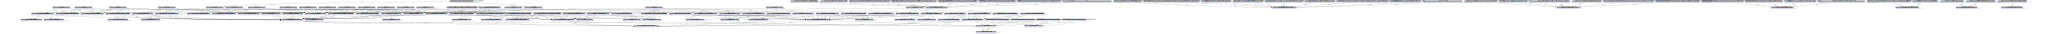

In [9]:
ret = d3f.query("""
prefix d3f: <http://d3fend.mitre.org/ontologies/d3fend.owl#> 

CONSTRUCT {
    ?object ?rel ?parent 
}
WHERE {
?object (<>|!<>)*  d3f:Harden;
?rel ?parent
.
FILTER (
! regex( str(?rel),"kb-", "i" )
)

#?parent (rdf:type|rdfs:subClassOf)* d3f:Harden

. FILTER (
regex(str(?parent), "http://d3fend.mitre.org", "i")
)
}
""")
show_svg(ret.graph)

# Digital objects

Those are the object to protect



In [37]:
overview = """

SELECT DISTINCT ?label, ?parents WHERE {

?object rdfs:subClassOf* d3f:DigitalObject ;
        rdfs:subClassOf [ rdfs:label ?parents ];
         rdfs:label ?label
. 

}

"""
sparql_dataframe.get(endpoint, prefixes+ overview)

,label,parents
0,Access Control List,Access Control Configuration
1,Group Policy,Access Control Configuration
2,Kerberos TIcket,Access Token
3,Ticket Granting Ticket,Access Token
4,Intranet Administrative Network Traffic,Administrative Network Traffic
...,...,...
461,Intranet Web Network Traffic,Web Network Traffic
462,Outbound Internet Web Traffic,Web Network Traffic
463,Artifact Server,Web Server
464,Web Application Server,Web Server


# Offensive objects

Offensive techniques model attacks, and have an attack-id. They are related to Offensive tactics.
While the ontology is very stratified, attacks can be identified via
- d3f:attack-id
- rdfs:subClassOf* ... OffensiveTechnique

In [43]:
# Offensive Techniques are associated to Offensive Tactics via d3f:enables

sparql_dataframe.get(
    endpoint, prefixes+ 
"""
SELECT DISTINCT ?attack, ?tactic 
WHERE {

?a (rdf:type|rdfs:subClassOf)* d3f:OffensiveTechnique;
  rdfs:label ?attack;
  d3f:enables ?tactic_u
.
 ?tactic_u   (rdf:type|rdfs:subClassOf)* d3f:OffensiveTactic;
    rdfs:label ?tactic
  
}
"""
                    )

,attack,tactic
0,Collection Technique,Collection
1,Command and Control Technique,Command And Control
2,Credential Access Technique,Credential Access
3,Defense Evasion Technique,Defense Evasion
4,Discovery Technique,Discovery
5,Execution Technique,Execution
6,Exfiltration Technique,Exfiltration
7,Impact Technique,Impact
8,Initial Access Technique,Initial Access
9,Lateral Movement Technique,Lateral Movement


To map attacks and Artifacts

In [ ]:
overview = """

SELECT DISTINCT * WHERE {

?attack_u
         rdfs:subClassOf* d3f:OffensiveTechnique ;
         rdfs:label ?label;
         d3f:attack-id ?id;
         ?attacks ?off_artifact_u
         
. ?off_artifact_u
    rdfs:subClassOf* d3f:DigitalArtifact;
    rdfs:label ?off_artifact
    
. ?attacks rdfs:label ?attacks_label
             
}

"""
df = sparql_dataframe.get(endpoint, prefixes+ overview)

In [ ]:
We can graph the relations between OffensiveTechniques and d3f:DigitalArtifacts

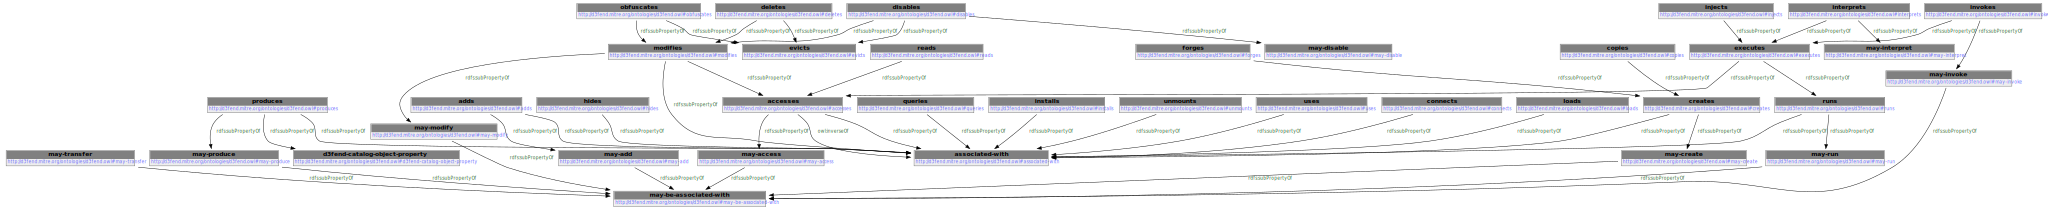

In [64]:
needle = ' '.join([f"(d3f:{x})" for x in df.attacks_label.unique()])
ret = d3f.query("""
CONSTRUCT {
?s ?rel ?q
}
WHERE {
VALUES (?s) { """ + needle+ """}
. ?s rdfs:subPropertyOf ?q;
   ?rel ?q
}
""")
show_svg(ret.graph)


In [23]:
overview = """

SELECT DISTINCT * WHERE {

?attacks rdfs:subClassOf* d3f:OffensiveTechnique ;
         rdfs:label ?attack_label;
         d3f:attack-id ?attack_id;
         ?a ?tgt 
. ?tgt (rdf:type|rdfs:subClassOf) d3f:ServiceApplication;
        rdfs:label ?tgt_label

.  ?a rdfs:label ?action ;
            rdfs:subPropertyOf* d3f:may-be-associated-with 
  
}
ORDER BY (?tgt_label)
"""
sparql_dataframe.get(endpoint, prefixes+ overview)

,attacks,attack_label,attack_id,a,tgt,tgt_label,action
0,http://d3fend.mitre.org/ontologies/d3fend.owl#...,LSASS Memory,T1003.001,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Authentication Service,accesses
1,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Security Account Manager,T1003.002,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Authentication Service,may-access
2,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Exploitation for Credential Access,T1212,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Authentication Service,may-access
3,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Use Alternate Authentication Material,T1550,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Authentication Service,accesses
4,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Modify Authentication Process,T1556,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Authentication Service,modifies
5,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Exploitation for Credential Access,T1212,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Credential Management System,may-access
6,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Transport Agent,T1505.002,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Message Transfer Agent,adds
7,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Software Deployment Tools Execution,T1072,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Software Deployment Tool,executes
8,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Run Virtual Instance,T1564.006,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Virtualization Software,may-add
9,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Run Virtual Instance,T1564.006,http://d3fend.mitre.org/ontologies/d3fend.owl#...,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Virtualization Software,executes


In [24]:
overview = """

SELECT DISTINCT * WHERE {

?attacks rdfs:subClassOf* d3f:OffensiveTechnique ;
         rdfs:label ?label;
         d3f:attack-id ?id;
         _:action ?tgt 
. ?tgt rdfs:subClassOf* d3f:Artifact;
        rdfs:label ?tgt_label

. { _:action rdfs:label ?action ;
             rdfs:subPropertyOf d3f:associated-with 
   } UNION {
    _:action rdfs:label ?action ;
             rdfs:subPropertyOf d3f:may-be-associated-with 
  } 
             
}

"""
sparql_dataframe.get(endpoint, prefixes+ overview)

,attacks,label,id,tgt,tgt_label,action
0,http://d3fend.mitre.org/ontologies/d3fend.owl#...,OS Credential Dumping,T1003,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Credential,accesses
1,http://d3fend.mitre.org/ontologies/d3fend.owl#...,LSASS Memory,T1003.001,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Authentication Service,accesses
2,http://d3fend.mitre.org/ontologies/d3fend.owl#...,LSASS Memory,T1003.001,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Process,accesses
3,http://d3fend.mitre.org/ontologies/d3fend.owl#...,NTDS,T1003.003,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Encrypted Credential,accesses
4,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Cached Domain Credentials,T1003.005,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Encrypted Credential,accesses
...,...,...,...,...,...,...
404,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Exfiltration to Code Repository,T1567.001,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Outbound Internet Encrypted Web Traffic,may-produce
405,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Asymmetric Cryptography,T1573.002,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Certificate File,may-transfer
406,http://d3fend.mitre.org/ontologies/d3fend.owl#...,DLL Search Order Hijacking,T1574.001,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Shared Library File,may-create
407,http://d3fend.mitre.org/ontologies/d3fend.owl#...,DLL Side-Loading,T1574.002,http://d3fend.mitre.org/ontologies/d3fend.owl#...,Shared Library File,may-create


In [25]:
# Hierarchy between ObjectProperty
# - d3f:may-be-associated-with links Assets/Artifacts to attacks

CONSTRUCT_RL="""
CONSTRUCT {
?Concept ?rel ?parent
}

where {
?Concept a owl:ObjectProperty;
  rdfs:subPropertyOf ?parent;
  ?rel ?parent 
}
"""
ret = d3f.query(CONSTRUCT_RL)
visualize(ret.graph)

In [26]:
ret = d3f.query("""
SELECT DISTINCT *
WHERE {

  d3f:analyzes rdfs:subPropertyOf* ?parent
  
}
""")

print(ret.bindings)

[{rdflib.term.Variable('parent'): rdflib.term.URIRef('http://d3fend.mitre.org/ontologies/d3fend.owl#analyzes')}, {rdflib.term.Variable('parent'): rdflib.term.URIRef('http://d3fend.mitre.org/ontologies/d3fend.owl#associated-with')}, {rdflib.term.Variable('parent'): rdflib.term.URIRef('http://d3fend.mitre.org/ontologies/d3fend.owl#may-be-associated-with')}, {rdflib.term.Variable('parent'): rdflib.term.URIRef('http://www.w3.org/2002/07/owl#topObjectProperty')}, {rdflib.term.Variable('parent'): rdflib.term.URIRef('http://d3fend.mitre.org/ontologies/d3fend.owl#detects')}, {rdflib.term.Variable('parent'): rdflib.term.URIRef('http://d3fend.mitre.org/ontologies/d3fend.owl#counters')}, {rdflib.term.Variable('parent'): rdflib.term.URIRef('http://d3fend.mitre.org/ontologies/d3fend.owl#d3fend-catalog-object-property')}, {rdflib.term.Variable('parent'): rdflib.term.URIRef('http://d3fend.mitre.org/ontologies/d3fend.owl#may-counter')}, {rdflib.term.Variable('parent'): rdflib.term.URIRef('http://d3fen

# Attacks for a given object

Once identified an object, eg. `d3f:ServiceApplication` you can track all
relevant attacks with the query below.

In [ ]:
target = "d3f:ServiceApplication"
g=Graph()
overview = f"""
prefix d3f: <http://d3fend.mitre.org/ontologies/d3fend.owl#> 

CONSTRUCT {{
  ?attack ?affects ?target
}}
WHERE {{

?attack rdfs:subClassOf* d3f:OffensiveTechnique ;
         rdfs:label ?attack_label;
         d3f:attack-id ?id;
         ?affects ?target

. ?target (rdf:type|rdfs:subClassOf)* d3f:ServiceApplication;
             rdfs:label ?target_label
.  ?affects rdfs:label ?action ;
            rdfs:subPropertyOf* d3f:may-be-associated-with 

}}
"""
#sparql_dataframe.get(endpoint, prefixes+ overview)
ret = from_sparql(overview)
visualize(ret)

## Identify defensive techniques 

Defensive techniques have the `d3f:d3fend-id` property, and are related to specific
`def:DigitalAssets`.


In [ ]:
target = "d3f:OperatingSystemProcess"
overview = f"""
prefix d3f: <http://d3fend.mitre.org/ontologies/d3fend.owl#> 

CONSTRUCT {{ ?measure ?protects {target} }}
WHERE {{

?measure 
         rdfs:label ?defend_label;
         d3f:d3fend-id ?defend_id;
         ?protects ?target

# Tutto ciò che difende un oggetto o le sue superclassi
. ?target ^(rdf:type|rdfs:subClassOf)* {target}

.  ?protects rdfs:subPropertyOf* d3f:may-be-associated-with
}}
"""

ret = from_sparql(overview)
visualize(ret)

In [34]:
# Defensive techniques and tactics

sparql_dataframe.get(
    endpoint, prefixes+ 
"""
SELECT DISTINCT  ?tactic, ?defense 
WHERE {

?d (rdf:type|rdfs:subClassOf)* d3f:DefensiveTechnique;
  rdfs:label ?defense;
  d3f:enables ?tactic_u
.
 ?tactic_u   (rdf:type|rdfs:subClassOf)* d3f:DefensiveTactic;
    rdfs:label ?tactic
  
}
ORDER BY ?tactic
"""
                    )

,tactic,defense
0,Deceive,Decoy Environment
1,Deceive,Decoy Object
2,Defensive Tactic,Defensive Technique
3,Detect,File Analysis
4,Detect,Identifier Analysis
5,Detect,Message Analysis
6,Detect,Network Traffic Analysis
7,Detect,Operating System Monitoring
8,Detect,Platform Monitoring
9,Detect,Process Analysis


## Correlate Attack and Defense techniques


In [30]:
target = "d3f:OperatingSystemProcess"

overview = f"""
prefix d3f: <http://d3fend.mitre.org/ontologies/d3fend.owl#> 

CONSTRUCT {{
  ?measure ?protects ?attack
}}
WHERE {{

?attack rdfs:subClassOf* d3f:OffensiveTechnique ;
         rdfs:label ?attack_label;
         d3f:attack-id ?id;
         ?affects ?targeta

. ?targeta (rdf:type|rdfs:subClassOf)* {target};
             rdfs:label ?target_label
.  ?affects rdfs:label ?action ;
            rdfs:subPropertyOf* d3f:may-be-associated-with 

. ?measure 
         rdfs:label ?defend_label;
         d3f:d3fend-id ?defend_id;
         ?protects ?targetb

# Tutto ciò che difende un oggetto o le sue superclassi
. ?target ^(rdf:type|rdfs:subClassOf)* ?targeta

.  ?protects rdfs:subPropertyOf* d3f:may-be-associated-with


}}

"""
#sparql_dataframe.get(endpoint, prefixes+ overview)
ret = from_sparql(overview)
show_svg(ret)

In [28]:
print(ret.serialize())

@prefix ns2: <http://d3fend.mitre.org/ontologies/d3fend.owl#> .

ns2:AccountLocking ns2:disables ns2:T1562.001 .

ns2:AdministrativeNetworkActivityAnalysis ns2:analyzes ns2:T1562.001 .

ns2:ApplicationConfigurationHardening ns2:hardens ns2:T1562.001 .

ns2:ApplicationHardening ns2:enables ns2:T1562.001 .

ns2:AuthenticationCacheInvalidation ns2:deletes ns2:T1562.001 .

ns2:AuthenticationEventThresholding ns2:analyzes ns2:T1562.001 .

ns2:AuthorizationEventThresholding ns2:analyzes ns2:T1562.001 .

ns2:BootloaderAuthentication ns2:authenticates ns2:T1562.001 .

ns2:BroadcastDomainIsolation ns2:filters ns2:T1562.001 .

ns2:CertificateAnalysis ns2:analyzes ns2:T1562.001 .

ns2:CertificatePinning ns2:authenticates ns2:T1562.001 .

ns2:Client-serverPayloadProfiling ns2:analyzes ns2:T1562.001 .

ns2:ConnectedHoneynet ns2:spoofs ns2:T1562.001 .

ns2:ConnectionAttemptAnalysis ns2:analyzes ns2:T1562.001 .

ns2:CredentialCompromiseScopeAnalysis ns2:analyzes ns2:T1562.001 .

ns2:CredentialEvictio

In [ ]:
target = "d3f:OperatingSystemProcess"

overview = f"""
prefix d3f: <http://d3fend.mitre.org/ontologies/d3fend.owl#> 

SELECT DISTINCT
 ?attack_label ?action ?defend_label ?protects_label ?super_target_label   
  

WHERE {{

?attack 
         rdfs:label ?attack_label;
         d3f:attack-id ?id;
         ?affects ?targeta

. ?targeta (rdf:type|rdfs:subClassOf)* {target};
             rdfs:label ?target_label
.  ?affects rdfs:label ?action ;
            rdfs:subPropertyOf* d3f:may-be-associated-with 
###
. ?targeth ^(rdf:type|rdfs:subClassOf)? {target};
  rdfs:label ?super_target_label
.
 FILTER (?targeth != owl:Class )

###
. ?measure 
         rdfs:label ?defend_label;
         d3f:d3fend-id ?defend_id;
         ?protects ?targeth


. ?protects rdfs:label ?protects_label
}}

"""
sparql_dataframe.get(endpoint, prefixes+ overview)
